In [1]:
%load_ext watermark
%watermark
from copy import deepcopy
import pickle
import os

import pandas as pd
import pandas_datareader.data as web
from pandas.tseries.offsets import Week
import numpy as np
import sklearn.mixture as mix
from sklearn.externals import joblib
import scipy.stats as scs
from math import ceil

import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':'Courier Prime Code', 'legend.frameon': True} # 
sns.set_style('white', style_kwds)

import missingno as msno
from tqdm import tqdm
import affirm 
import warnings
warnings.filterwarnings("ignore")
import re
p=print
p()
%watermark -p pandas,pandas_datareader,numpy,scipy,sklearn,matplotlib,seaborn

2017-04-25T00:32:39-06:00

CPython 3.6.0
IPython 5.1.0

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.4.0-72-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit

pandas 0.19.2
pandas_datareader 0.3.0.post
numpy 1.12.1
scipy 0.19.0
sklearn 0.18.1
matplotlib 2.0.0
seaborn 0.7.1


In [2]:
nSamples = 1_000
year = 2007 # cutoff
lookback = 1 # years
step_fwd = 3 # days
ks = [2,3,5,7,9,13,17,21]
chosen_etfs = ['SPY', 'QQQ', 'TLT', 'GLD', 'EFA', 'EEM']

def _create_dir(DIR, k, lookback, step_fwd, nSamples, year):
    dir_fmt = f'k-{k}_lb-{lookback}_step-{step_fwd}_nsamples-{nSamples}'
    if os.path.isdir(DIR + dir_fmt + '/'): 
        pass
    else: os.makedirs(DIR + dir_fmt + '/')
    return dir_fmt

In [4]:
#pkl_loc = '/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/chosen_etf_agg_ks_trim/'
pkl_loc = '/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/agg_result_eval/Lookback-Expanding/'
#f_suffix = f'k-multiple_lb-{lookback}_step-{step_fwd}_nsamples-{nSamples}.txt'
f_suffix = f'k-multiple_lb-expanding_step-{step_fwd}_nsamples-{nSamples}.txt'
f_suffix

'k-multiple_lb-expanding_step-3_nsamples-1000.txt'

In [3]:
import sys
DIR = '/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/'
sys.path.append(DIR)
import ResultEval 
import ModelPlots

In [7]:
# get summaries?
smmry_f = '/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/agg_result_eval/Lookback-Expanding/smmrys_k-multiple_lb-expanding_step-3_nsamples-1000.txt'
with open(smmry_f, 'rb') as f:
    smmrys = pickle.load(f)
smmrys

[(2,
  'SPY',
           mean  median    max_     min_ gt0_cnt lt0_cnt sum_gt0  sum_lt0  \
  value  0.0002  0.0028  0.1269  -0.1437     179     139  2.9982  -2.9450   
  
        sum_ratio  gt_pct  lt_pct  
  value    1.0181  0.5629  0.4371  ),
 (2,
  'QQQ',
            mean  median    max_     min_ gt0_cnt lt0_cnt sum_gt0  sum_lt0  \
  value  -0.0008  0.0023  0.0815  -0.1183     117     104  2.1483  -2.3142   
  
        sum_ratio  gt_pct  lt_pct  
  value    0.9283  0.5294  0.4706  ),
 (2,
  'TLT',
           mean  median    max_     min_ gt0_cnt lt0_cnt sum_gt0  sum_lt0  \
  value  0.0018  0.0014  0.0823  -0.0623     214     183  3.0058  -2.3035   
  
        sum_ratio  gt_pct  lt_pct  
  value    1.3049  0.5390  0.4610  ),
 (2,
  'GLD',
           mean  median    max_     min_ gt0_cnt lt0_cnt sum_gt0  sum_lt0  \
  value  0.0011  0.0030  0.0645  -0.1381     115      88  1.8027  -1.5881   
  
        sum_ratio  gt_pct  lt_pct  
  value    1.1351  0.5665  0.4335  ),
 (2,
  'EFA',
    

In [11]:
smmrys[0][-1].columns.tolist()

['mean',
 'median',
 'max_',
 'min_',
 'gt0_cnt',
 'lt0_cnt',
 'sum_gt0',
 'sum_lt0',
 'sum_ratio',
 'gt_pct',
 'lt_pct']

In [56]:
cols = ['sym', 'lookback', 'accuracy', 'k', 'steps'] + smmrys[0][-1].columns.tolist() # add in follow up?  'start_date', 'end_date',
cols

['sym',
 'lookback',
 'accuracy',
 'k',
 'steps',
 'mean',
 'median',
 'max_',
 'min_',
 'gt0_cnt',
 'lt0_cnt',
 'sum_gt0',
 'sum_lt0',
 'sum_ratio',
 'gt_pct',
 'lt_pct']

In [18]:
# get post events


In [6]:
# import dict of predictions
# dcts is list of tuples 
#   with tuple = (k, sym, dict)
#     dict = {a, b, pred-df, cutoff-year}
f_suffix = f'k-multiple_lb-expanding_step-{step_fwd}_nsamples-{nSamples}.txt'
dcts_k_f = pkl_loc + 'dcts_' + f_suffix
#dcts_k_f

with open(dcts_k_f, 'rb') as f:
    dcts = pickle.load(f)

In [61]:
%%time
step_fwds = [1, 2, 3, 5, 7, 10, 21]

agg_rows = []

# agg_etf_ret_by_step is a dict
# key = ETF-symbol, value = list[] of tuples()
lookbacks = [999, 1, 3] # 999 is expanding lookback
# import dict of predictions
# dcts is list of tuples 
#   with tuple = (k, sym, dict)
#     dict = {a, b, pred-df, cutoff-year}
for lookback in lookbacks:
    if lookback == 999:
        pkl_loc = '/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/agg_result_eval/Lookback-Expanding/'
        f_suffix = f'k-multiple_lb-expanding_step-{step_fwd}_nsamples-{nSamples}.txt'
    else: 
        pkl_loc = f'/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/agg_result_eval/Lookback-{lookback}-years/'
        f_suffix = f'k-multiple_lb-{lookback}_step-{step_fwd}_nsamples-{nSamples}.txt'
    dcts_k_f = pkl_loc + 'dcts_' + f_suffix
    with open(dcts_k_f, 'rb') as f:
        dcts = pickle.load(f)

    for etf in chosen_etfs:        
        # agg_ret_by_step is a temp list
        #  holds identifying information and the etf returns
        agg_rows_by_step = []
        for tup in dcts:
            if tup[1] == etf:
                for step in step_fwds:
                    # return k, mkt-symbol and prediction dict from tuple
                    k, tmpetf, tmp_data = tup[0], tup[1], tup[2] 
                    pred_df = tmp_data['pred']
                    nRight = pred_df.query('in_rng==1').shape[0]
                    accuracy = nRight / pred_df.shape[0]

                    # evaluate data by step_fwd
                    rev = ResultEval.ResultEval(data=tmp_data, step_fwd=step)
                    event_dict = rev.get_event_states()
                    #p(event_dict)
                    # [0]= TOO_HIGH, [1] = TOO_LOW
                    event = list(event_dict.keys())[1] 

                    pev = rev.get_post_events(event_dict[event])
                    end_vals = rev.get_end_vals(pev)
                    smry = rev.create_summary(end_vals)
                    #p(etf_return_data)

                    row = [tmpetf, lookback, accuracy, k, step] + list(smry.values.ravel())
                    agg_rows.append(row)           


'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute 'iloc'

'numpy.float64' object has no attribute

In [120]:
df = (pd.DataFrame(agg_rows, columns=cols).apply(pd.to_numeric, errors='ignore'))
df.head()

,sym,lookback,accuracy,k,steps,mean,median,max_,min_,gt0_cnt,lt0_cnt,sum_gt0,sum_lt0,sum_ratio,gt_pct,lt_pct
0,SPY,999,0.628002,2,1,0.0009,0.0013,0.0605,-0.0771,178,140,1.7614,-1.4754,1.1939,0.5597,0.4403
1,SPY,999,0.628002,2,2,0.0005,0.0008,0.1195,-0.0979,168,150,2.4720,-2.2976,1.0759,0.5283,0.4717
2,SPY,999,0.628002,2,3,0.0002,0.0028,0.1269,-0.1437,179,139,2.9982,-2.9450,1.0181,0.5629,0.4371
3,SPY,999,0.628002,2,5,0.0025,0.0059,0.1773,-0.2410,194,124,4.1980,-3.3977,1.2355,0.6101,0.3899
4,SPY,999,0.628002,2,7,0.0024,0.0063,0.1429,-0.2491,187,131,4.7394,-3.9715,1.1933,0.5881,0.4119


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 16 columns):
sym          1008 non-null object
lookback     1008 non-null int64
accuracy     1008 non-null float64
k            1008 non-null int64
steps        1008 non-null int64
mean         1008 non-null float64
median       1008 non-null float64
max_         1008 non-null float64
min_         1008 non-null float64
gt0_cnt      1008 non-null int64
lt0_cnt      1008 non-null int64
sum_gt0      1008 non-null float64
sum_lt0      1008 non-null float64
sum_ratio    1008 non-null float64
gt_pct       1008 non-null float64
lt_pct       1008 non-null float64
dtypes: float64(10), int64(5), object(1)
memory usage: 126.1+ KB


In [64]:
DIR2 = '/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/agg_result_eval/'
df.to_hdf(DIR2 + 'GMM_Results_TidyData.h5', 'table')

In [137]:
# can view individual results
df.query('sym == "SPY"').groupby(['k', 'steps','lookback']).mean().T

k                 2                                                  \
steps             1                                  2                
lookback         1           3           999        1           3     
accuracy     0.72406    0.751246    0.628002    0.72406    0.751246   
mean         0.00130    0.001100    0.000900    0.00060    0.001500   
median       0.00130    0.002000    0.001300    0.00070    0.002100   
max_         0.04550    0.052500    0.060500    0.06820    0.119500   
min_        -0.04580   -0.077100   -0.077100   -0.07360   -0.097900   
gt0_cnt    118.00000  110.000000  178.000000  108.00000  109.000000   
lt0_cnt     89.00000   87.000000  140.000000   99.00000   88.000000   
sum_gt0      1.01060    1.185000    1.761400    1.35450    1.732300   
sum_lt0     -0.73200   -0.975700   -1.475400   -1.22740   -1.439600   
sum_ratio    1.38060    1.214600    1.193900    1.10350    1.203300   
gt_pct       0.57000    0.558400    0.559700    0.52170    0.553300   
lt_pct       0.43000    0.441600    0.440300    0.47830    0.446700   

k                                                                    \
steps                         3                                  5    
lookback          999        1           3           999        1     
accuracy     0.628002    0.72406    0.751246    0.628002    0.72406   
mean         0.000500    0.00120    0.001400    0.000200    0.00330   
median       0.000800    0.00310    0.003700    0.002800    0.00640   
max_         0.119500    0.09320    0.126900    0.126900    0.07180   
min_        -0.097900   -0.14370   -0.143700   -0.143700   -0.18320   
gt0_cnt    168.000000  122.00000  118.000000  179.000000  130.00000   
lt0_cnt    150.000000   85.00000   79.000000  139.000000   77.00000   
sum_gt0      2.472000    1.80610    2.072300    2.998200    2.31640   
sum_lt0     -2.297600   -1.55860   -1.795600   -2.945000   -1.62370   
sum_ratio    1.075900    1.15880    1.154100    1.018100    1.42660   
gt_pct       0.528300    0.58940    0.599000    0.562900    0.62800   
lt_pct       0.471700    0.41060    0.401000    0.437100    0.37200   

k             ...              21                                      \
steps         ...              5           7                            
lookback      ...             999         1           3           999   
accuracy      ...        0.681921    0.435433    0.599909    0.681921   
mean          ...        0.001900    0.001600    0.004400    0.001900   
median        ...        0.005000    0.004100    0.005200    0.004800   
max_          ...        0.107800    0.122400    0.142900    0.160000   
min_          ...       -0.209600   -0.189100   -0.249100   -0.271100   
gt0_cnt       ...      154.000000  338.000000  212.000000  144.000000   
lt0_cnt       ...      104.000000  237.000000  144.000000  114.000000   
sum_gt0       ...        2.959200    6.005200    4.607100    3.430500   
sum_lt0       ...       -2.476800   -5.058400   -3.029000   -2.944600   
sum_ratio     ...        1.194800    1.187200    1.521000    1.165000   
gt_pct        ...        0.596900    0.587800    0.595500    0.558100   
lt_pct        ...        0.403100    0.412200    0.404500    0.441900   

k                                                                      \
steps              10                                  21               
lookback          1           3           999         1           3     
accuracy     0.435433    0.599909    0.681921    0.435433    0.599909   
mean         0.002100    0.004500    0.001900    0.003300    0.001700   
median       0.006000    0.008000    0.007200    0.011400    0.009500   
max_         0.153100    0.153100    0.195400    0.173800    0.151200   
min_        -0.311500   -0.317900   -0.348800   -0.427000   -0.427000   
gt0_cnt    345.000000  213.000000  152.000000  354.000000  211.000000   
lt0_cnt    230.000000  143.000000  106.000000  221.000000  145.000000   
sum_gt0      7.510500    5.393200    4.055

In [138]:
df.query('sym == "SPY"').groupby(['k', 'steps','lookback'])['sum_ratio'].mean().unstack()

lookback     1       3       999
k  steps                        
2  1      1.3806  1.2146  1.1939
   2      1.1035  1.2033  1.0759
   3      1.1588  1.1541  1.0181
   5      1.4266  1.2988  1.2355
   7      1.3061  1.2181  1.1933
   10     1.2528  1.1140  1.1013
   21     1.1795  0.9939  1.0623
3  1      1.5326  1.3799  1.1629
   2      1.2588  1.0730  0.9559
   3      1.2554  1.0362  0.9248
   5      1.4943  1.1174  1.0305
   7      1.3562  1.1055  1.0608
   10     1.3104  1.0478  0.9581
   21     1.1694  1.0987  1.0401
5  1      1.2299  1.3337  1.1743
   2      1.1551  1.0618  0.9798
   3      1.1248  1.1060  0.9332
   5      1.4150  1.4754  1.1586
   7      1.3135  1.4061  1.2162
   10     1.1943  1.3099  1.0387
   21     1.0959  1.1919  0.8289
7  1      1.0653  1.5026  1.2731
   2      1.0596  1.0715  1.0788
   3      1.1546  1.0525  1.1063
   5      1.4114  1.4787  1.3386
   7      1.2811  1.4847  1.2621
   10     1.2368  1.3933  1.2419
   21     1.3120  1.1530  1.0946
9  1      1.0479  1.3456  1.3508
   2      1.0196  1.0609  1.1059
   3      1.1100  1.0403  1.1713
   5      1.3666  1.2846  1.4543
   7      1.3124  1.1804  1.4201
   10     1.2260  1.1591  1.2543
   21     1.2077  1.0994  1.2401
13 1      1.1263  1.1889  1.4211
   2      1.0648  1.0269  1.1443
   3      1.1574  1.0529  1.2717
   5      1.3378  1.2382  1.3161
   7      1.2053  1.1437  1.2919
   10     1.1588  1.1268  1.1386
   21     1.3624  1.0367  0.9793
17 1      1.2072  1.2717  1.1266
   2      1.2261  1.1880  0.8662
   3      1.1569  1.2243  0.9143
   5      1.2874  1.2782  1.1725
   7      1.3338  1.0865  1.0402
   10     1.3186  1.1162  0.9493
   21     1.3412  1.0565  0.7675
21 1      1.1376  1.4016  1.3197
   2      1.1715  1.3162  1.0202
   3      1.1335  1.3548  1.0144
   5      1.2000  1.5998  1.1948
   7      1.1872  1.5210  1.1650
   10     1.1957  1.4193  1.1351
   21     1.2039  1.0952  1.0462

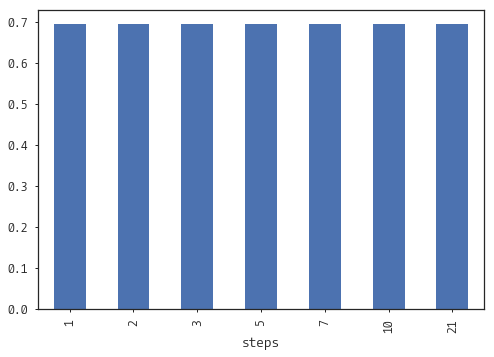

In [68]:
df.groupby(['sym','steps'])['accuracy'].mean().unstack().mean().plot(kind='bar')

In [54]:
df.groupby(['sym','steps'])['accuracy'].mean().stack().mean().plot(kind='bar')

AttributeError: 'Series' object has no attribute 'stack'

In [95]:
def plot_bar(series, x_label, y_label):
    plt.style.use('bmh')
    fig, ax = plt.subplots(figsize=(10,7))
    ax.axhline(y=0, color='k')
    series.plot(kind='bar', ax=ax)
    ETF_avg = series.mean()
    ax.axhline(y=ETF_avg, color='red', ls='--')
    # annotate the avg
    lo, hi = ax.get_ylim()
    bbox_props = dict(boxstyle="round4, pad=0.6", fc="cyan", ec="b", lw=.5)
    ax.annotate(f'ETF average return: {ETF_avg:3.2%}', 
                fontsize=12, fontweight='demi',
                xy=(0, ETF_avg), 
                xycoords='data', 
                xytext=(.05, (hi-lo)*.65 ), 
                #textcoords = 'offset points',
                arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2"),
                bbox=bbox_props               )
    plt.title(f'{series.name}')
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    #plt.tight_layout()
    #file_str = plot_loc + f'{series.name}-return-by-steps.png'
    #fig.savefig(file_str, dpi=300, bbox_inches="tight")
    #plt.close(fig)
    return

In [141]:
def plot_bar_num(series, x_label, y_label):
    plt.style.use('bmh')
    fig, ax = plt.subplots(figsize=(10,7))
    ax.axhline(y=0, color='k')
    series.plot(kind='bar', ax=ax)
    ETF_avg = series.mean()
    ax.axhline(y=ETF_avg, color='red', ls='--')
    # annotate the avg
    lo, hi = ax.get_ylim()
    bbox_props = dict(boxstyle="round4, pad=0.6", fc="cyan", ec="b", lw=.5)
    ax.annotate(f'ETF average {y_label}: {ETF_avg:3.2f}', 
                fontsize=12, fontweight='demi',
                xy=(0, ETF_avg), 
                xycoords='data', 
                xytext=(.05, (hi-lo)*.65 ), 
                #textcoords = 'offset points',
                arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2"),
                bbox=bbox_props               )
    plt.title(f'{series.name}')
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    #plt.tight_layout()
    #file_str = plot_loc + f'{series.name}-return-by-steps.png'
    #fig.savefig(file_str, dpi=300, bbox_inches="tight")
    #plt.close(fig)
    return

In [164]:
DIR = '/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/agg_result_eval/'

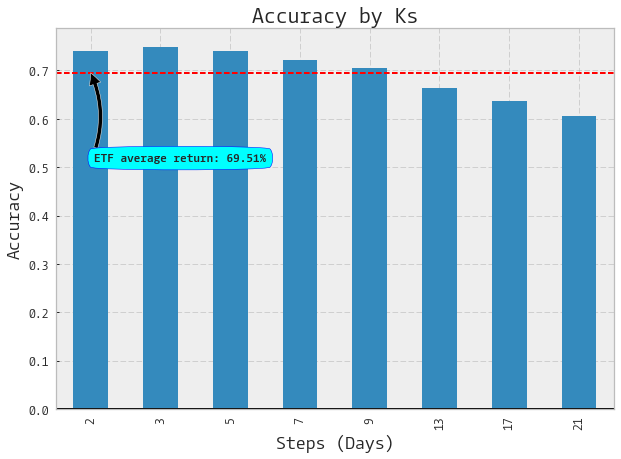

In [80]:
ser = df.groupby(['sym','k'])['accuracy'].mean().unstack().mean()
ser.name = 'Accuracy by Ks'
plot_bar(ser)

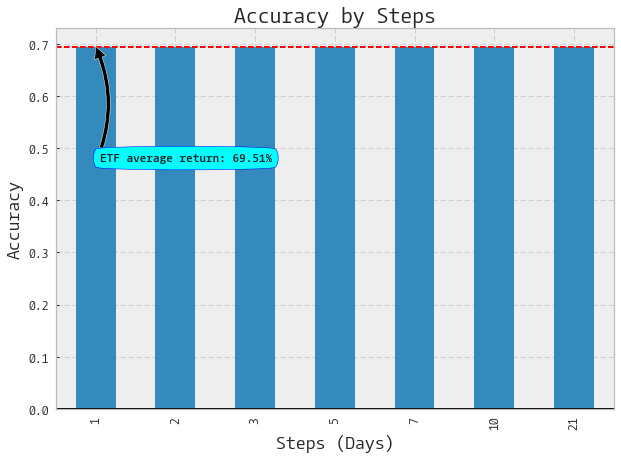

In [81]:
ser = df.groupby(['sym','steps'])['accuracy'].mean().unstack().mean()
ser.name = 'Accuracy by Steps'
plot_bar(ser)

In [82]:
df.head()

,sym,lookback,accuracy,k,steps,mean,median,max_,min_,gt0_cnt,lt0_cnt,sum_gt0,sum_lt0,sum_ratio,gt_pct,lt_pct
0,SPY,999,0.628002,2,1,0.0009,0.0013,0.0605,-0.0771,178,140,1.7614,-1.4754,1.1939,0.5597,0.4403
1,SPY,999,0.628002,2,2,0.0005,0.0008,0.1195,-0.0979,168,150,2.4720,-2.2976,1.0759,0.5283,0.4717
2,SPY,999,0.628002,2,3,0.0002,0.0028,0.1269,-0.1437,179,139,2.9982,-2.9450,1.0181,0.5629,0.4371
3,SPY,999,0.628002,2,5,0.0025,0.0059,0.1773,-0.2410,194,124,4.1980,-3.3977,1.2355,0.6101,0.3899
4,SPY,999,0.628002,2,7,0.0024,0.0063,0.1429,-0.2491,187,131,4.7394,-3.9715,1.1933,0.5881,0.4119


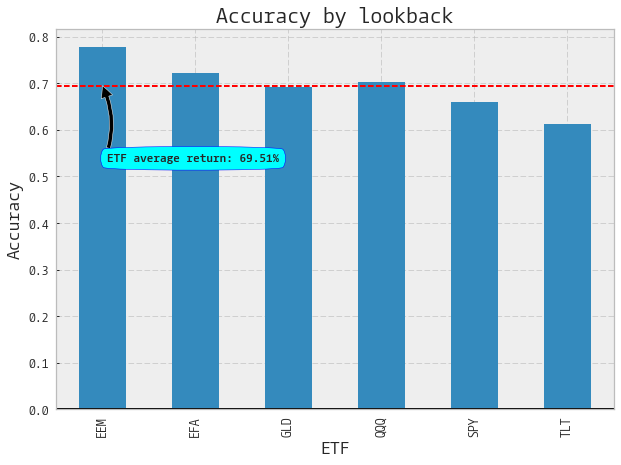

In [97]:
ser = df.groupby(['sym', 'lookback'])['accuracy'].mean().unstack().mean(axis=1)
ser.name = 'Accuracy by lookback'
plot_bar(ser, 'ETF', 'Accuracy')

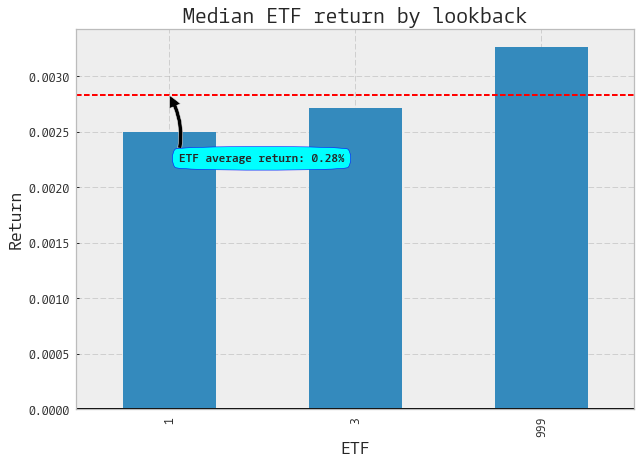

In [126]:
# returns
ser = df.groupby(['sym', 'lookback'])['median'].mean().unstack().mean(axis=0)
ser.name = 'Median ETF return by lookback'
plot_bar(ser, 'ETF', 'Return')

In [102]:
ser = df.groupby(['sym', 'lookback'])['median'].mean().unstack().mean(axis=1)
ser

sym
EEM    0.000977
EFA    0.002130
GLD    0.000771
QQQ    0.005810
SPY    0.004829
TLT    0.002437
dtype: float64

In [114]:
# median returns by K
df1 = df.groupby(['sym', 'k'])['median'].mean().unstack()#.mean(axis=1)
df1

k,2,3,5,7,9,13,17,21
sym,,,,,,,,
EEM,0.004195,0.000376,0.001681,0.001310,-0.000805,0.000771,0.000086,0.000205
EFA,0.003414,0.000990,0.002214,0.001810,0.002000,0.001990,0.001495,0.003129
GLD,0.000843,0.000952,0.000886,-0.000067,0.000867,0.001314,0.000581,0.000795
QQQ,0.006552,0.006690,0.005933,0.006000,0.005852,0.004971,0.005243,0.005233
SPY,0.006505,0.005195,0.004957,0.004757,0.004824,0.004262,0.003500,0.004629
TLT,0.003152,0.002310,0.001986,0.002248,0.002724,0.002233,0.002805,0.002038


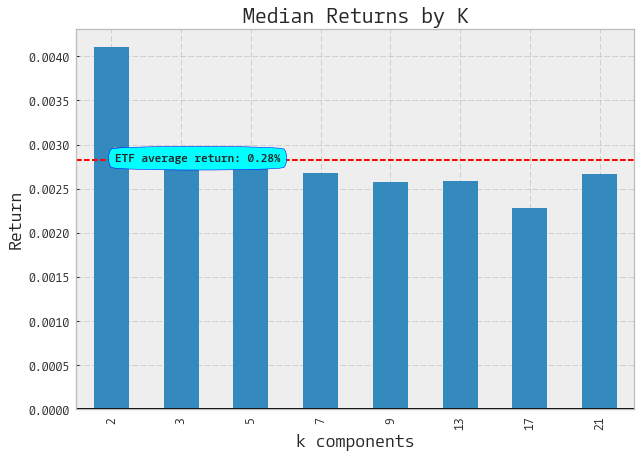

In [115]:
ser = df.mean(axis=0)
ser.name = 'Median Returns by K'
plot_bar(ser, 'k components', 'Return')

In [122]:
# median returns by step
df1 = df.groupby(['sym', 'steps'])['median'].mean().unstack()#.mean(axis=1)
df1

steps,1,2,3,5,7,10,21
sym,,,,,,,
EEM,0.001596,0.000096,-0.000592,0.002512,0.002221,0.003883,-0.002875
EFA,0.000558,0.000412,-0.000350,0.001842,0.005412,0.005479,0.001558
GLD,0.001063,0.000758,0.001408,0.000546,-0.001042,-0.000538,0.003204
QQQ,0.000217,0.000937,0.003329,0.006446,0.005383,0.009713,0.014642
SPY,0.001033,0.000675,0.002500,0.005063,0.004925,0.007425,0.012179
TLT,0.001521,0.000921,0.000821,0.002388,0.003367,0.002712,0.005329


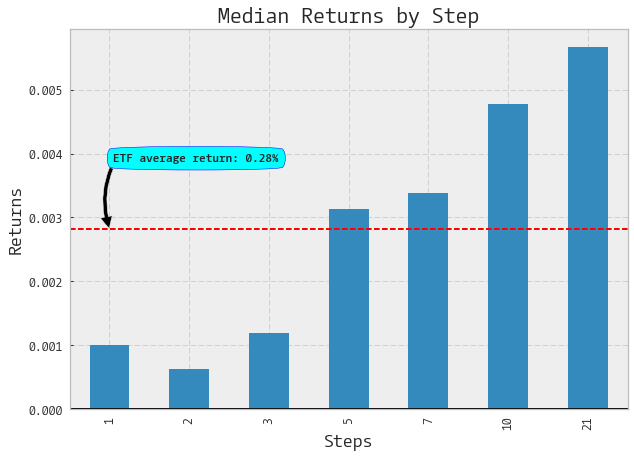

In [125]:
ser = df1.mean(axis=0)
ser.name = 'Median Returns by Step'
plot_bar(ser, 'Steps', 'Returns')

In [127]:
# sum ratio by step
df2 = df.groupby(['sym', 'steps'])['sum_ratio'].mean().unstack()#.mean(axis=1)
df2

steps,1,2,3,5,7,10,21
sym,,,,,,,
EEM,1.370908,1.069050,1.142558,1.218625,1.076463,0.993300,0.658767
EFA,1.261367,0.930817,0.925383,1.030763,1.040233,0.966746,0.670408
GLD,1.090254,1.015225,1.031525,0.989417,1.011271,1.036229,1.160317
QQQ,1.141629,1.113429,1.191242,1.367733,1.317471,1.274929,1.155454
SPY,1.266183,1.095317,1.109442,1.317129,1.253800,1.183212,1.110679
TLT,1.255213,1.123088,1.160733,1.350704,1.349554,1.461875,1.469208


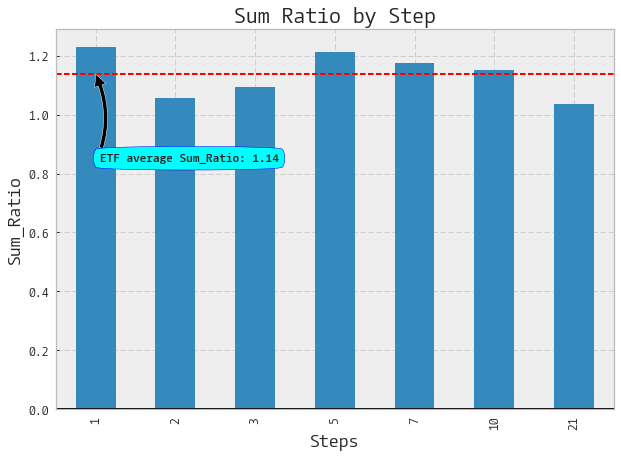

In [142]:
ser = df2.mean(axis=0)
ser.name = 'Sum Ratio by Step'
plot_bar_num(ser, 'Steps', 'Sum_Ratio')

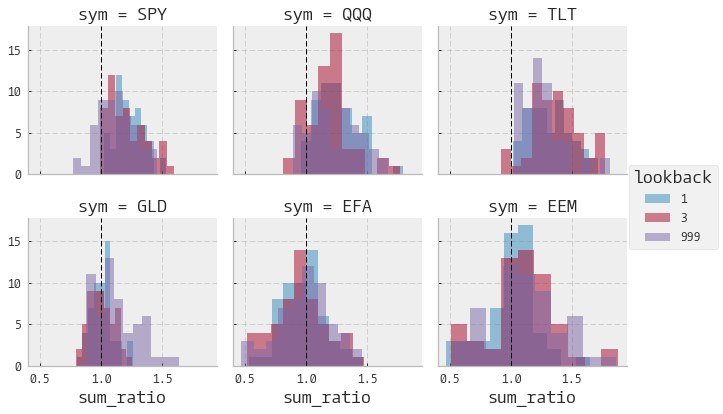

In [172]:
# fun with facet grids
g = sns.FacetGrid(df, col="sym", hue="lookback", col_wrap=3)
g.map(plt.hist, "sum_ratio", alpha=0.5);
g.add_legend();
for ax in g.axes.flat:
    ax.axvline(1, color='k', lw=1, ls='--')
g.fig.savefig(DIR + 'facetgrid-lookback-steps-sum-ratio-hist.png', dpi=300, bbox_inches='tight') 

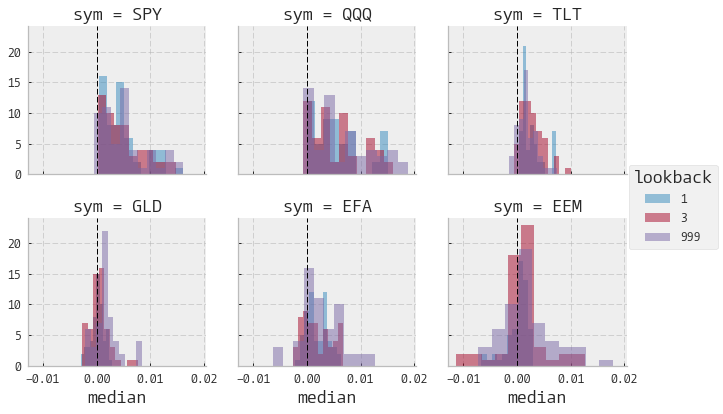

In [170]:
g = sns.FacetGrid(df, col="sym", hue="lookback", col_wrap=3)
g.map(plt.hist, "median", alpha=0.5);
g.add_legend();
for ax in g.axes.flat:
    ax.axvline(0, color='k', lw=1, ls='--')
g.fig.savefig(DIR + 'facetgrid-lookback-steps-median-return-hist.png', dpi=300, bbox_inches='tight')  

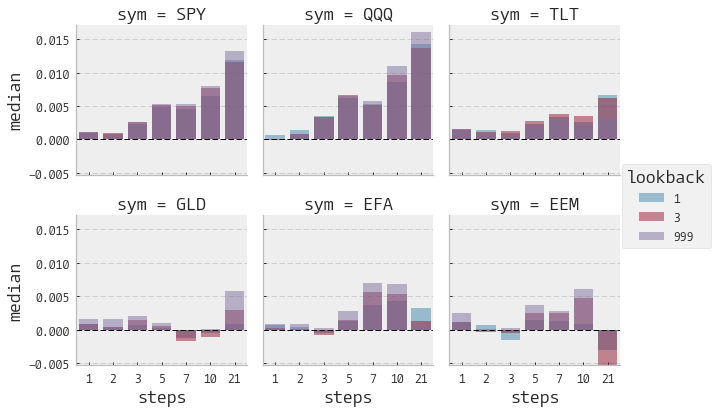

In [169]:
g = sns.FacetGrid(df, col="sym", hue="lookback", col_wrap=3)
g.map(sns.barplot, "steps", "median", ci=None, alpha=0.5)
g.add_legend();
for ax in g.axes.flat:
    ax.axhline(0, color='k', lw=1, ls='--')
g.fig.savefig(DIR + 'facetgrid-lookback-steps-median-return-barplot.png', dpi=300, bbox_inches='tight')    

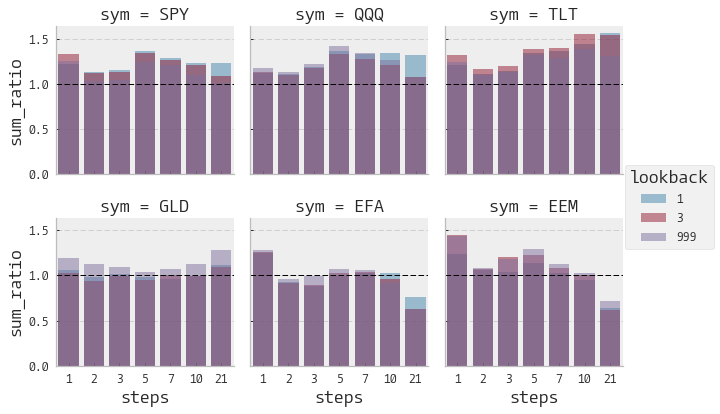

In [168]:
g = sns.FacetGrid(df, col="sym", hue="lookback", col_wrap=3)
g.map(sns.barplot, "steps", "sum_ratio", ci=None, alpha=0.5)
g.add_legend();
for ax in g.axes.flat:
    ax.axhline(1., color='k', lw=1, ls='--')
g.fig.savefig(DIR + 'facetgrid-lookback-steps-sum-ratio-barplot.png', dpi=300, bbox_inches='tight')

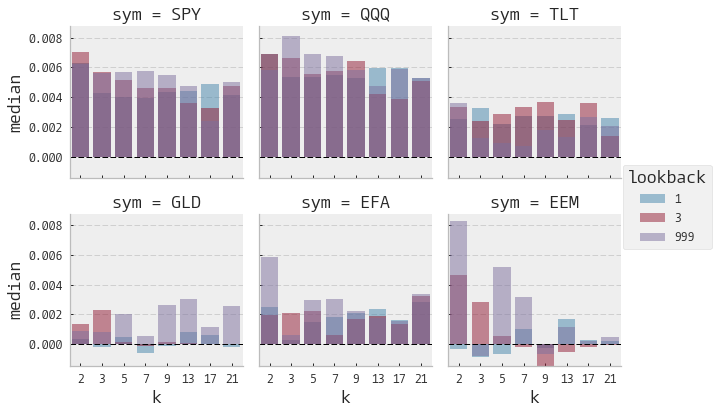

In [173]:
g = sns.FacetGrid(df, col="sym", hue="lookback", col_wrap=3)
g.map(sns.barplot, "k", "median", ci=None, alpha=0.5)
g.add_legend();
for ax in g.axes.flat:
    ax.axhline(0, color='k', lw=1, ls='--')
g.fig.savefig(DIR + 'facetgrid-lookback-k-median-return-barplot.png', dpi=300, bbox_inches='tight')   

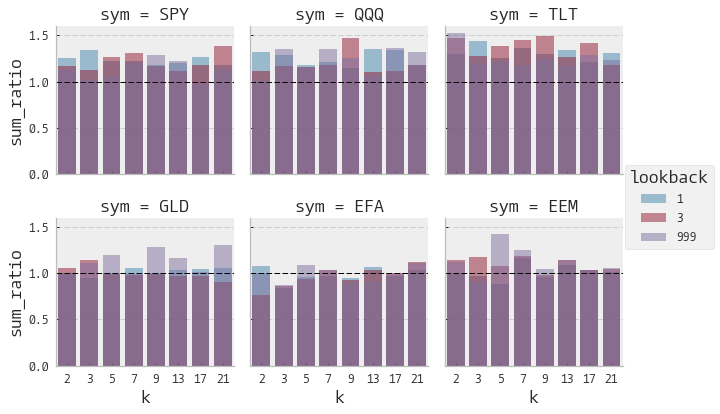

In [174]:
g = sns.FacetGrid(df, col="sym", hue="lookback", col_wrap=3)
g.map(sns.barplot, "k", "sum_ratio", ci=None, alpha=0.5)
g.add_legend();
for ax in g.axes.flat:
    ax.axhline(1., color='k', lw=1, ls='--')
g.fig.savefig(DIR + 'facetgrid-lookback-k-sum-ratio-barplot.png', dpi=300, bbox_inches='tight')

In [ ]:
g.